## INSH2120 - Final Project

**Group 7**

**Forrest Meng, Garrett Michiels, Timothy Mitchell, Gabriel Peter, Daniel Pickett**
<hr>

## <center>The Relationship between Bars and Colleges in Boston and Alcohol-Related Crimes </center>

### Introduction
We set out to determine if there is a relationship between areas containing bars and colleges and specific alcohol related crimes such as underage liquor violations. Identifying if certain areas are more prone to these crimes could help the city of Boston understand the issue and put in plans to reduce these crimes. Our process starts by looking into criminology to understand some reasons why crimes occur when applied to our question. Then we download various datasets from [data.boston.gov](https://data.boston.gov/) including crime reports, liquor licenses, and location of colleges to use for analysis. Finally, we create various visualizations and analyze the results.

#### Outline
- 1. [Background](#1)
- 2. [Read and Filter Data](#2)
- 3. [Spatial Joins / Aggregation](#3)
- 4. [Visualizations](#4)
- 5. [Analysis](#5)


<a id='1'></a>
## 1. Background
### Motivation

“In 2019, almost 2 out of 100 adolescents ages 12 to 13 reported drinking alcohol in the past month and fewer than 1 in 100 engaged in binge drinking. Among respondents ages 16 to 17, fewer than 1 in 5 reported drinking and about 1 in 10 reported binge drinking.5 It is important to implement prevention strategies during early adolescence to prevent this escalation.” - NIAAA<sup>1</sup>

Results:
- Increased death,
- Increased Injury
- Increases the risk of physical and sexual assault
- Interferes with brain development
- Future Alcoholism

1. “Underage Drinking.” National Institute on Alcohol Abuse and Alcoholism. U.S. Department of Health and Human Services. Accessed April 21, 2021. https://www.niaaa.nih.gov/publications/brochures-and-fact-sheets/underage-drinking. 

### Criminology Background

<img src="data/activity_theory.png" align="right" alt="Routine Activity Theory Venn Diagram" style="width:200px;">

Crime occurs when three elements converge:

- A motivated offender
- A suitable target
- The absence of a capable guardian



Cohen and Felson (1979)<sup>2</sup>

2. Smith, Clifton L, and David J Brooks. “Routine Activity Theory.” Science Direct. Accessed April 21, 2021. https://www.sciencedirect.com/topics/computer-science/routine-activity-theory. 

### Routine Activity Theory For Our Research Question

- We will focus on two of the mentioned elements: motivated offenders and suitable targets.

- With regards to alcohol related crimes, we view the <b>suitable target</b> as a place where a motivated offender can purchase or consume heavy amounts of alcohol (this could be a <b>bar/restaurant/liquor store</b>)

- A specific group of <b>motivated offenders</b> that we can track is <b>college students</b>

### Research Question

- We will identify any correlation between the number of alcohol-related crimes and the number of bars at a neighborhood level in Boston

- We will work with our data to clean it and format it to be used for statistical analysis and visualization

    - Create heat maps at neighborhood level showing both alcohol-related crime and number of bars
    - Overlay location of colleges on top


<a id='2'></a>
## 2. Read and Filter Data

### Imports

For this project we use the pandas, geopandas, and matplotlib modules

In [28]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

### Crime Dataset

From [data.boston.gov](https://data.boston.gov/dataset/crime-incident-reports-august-2015-to-date-source-new-system), we downloaded and read in the individual CSV for the crime incident reports from years 2015-2018. 2012-2015 is also available, but the system for the offense codes of crimes changed after this data was collected. We decided not to waste effort translating the old codes to the new codes, especially since the older data contained only about 10% of the records that the new data has.

We appended all the individual files from each year into one DataFrame, then selected the columns of interest. Namely, OFFENSE_CODE, OFFENSE_DESCRIPTION, YEAR, and Lat/Long.

In [29]:
crime_2015 = pd.read_csv('data/crime-incident-reports-2015.csv')
crime_2016 = pd.read_csv('data/crime-incident-reports-2015.csv')
crime_2017 = pd.read_csv('data/crime-incident-reports-2017.csv')
crime_2018 = pd.read_csv('data/crime-incident-reports-2018.csv')

In [30]:
crime = pd.DataFrame()
crime=crime.append(crime_2015, ignore_index=True)
crime=crime.append(crime_2016, ignore_index=True)
crime=crime.append(crime_2017, ignore_index=True)
crime=crime.append(crime_2018, ignore_index=True)
crime=crime[['OFFENSE_CODE', 'OFFENSE_DESCRIPTION', 'YEAR', 'Lat', 'Long']]

### Liquor Licenses Dataset

Again from [data.boston.gov](https://data.boston.gov/dataset/liquor-licenses), we downloaded and read the CSV containing info about liquor licenses in Boston. We select only the license ID, the issuing date, the type of license, the status of the license ('Active', etc.), the establishment name, and the GPSX and GPSY coordinates.

In [31]:
alc = pd.read_csv('data/blb_section_12_alcohol.csv')
alc=alc[['license_num', 'issued', 'license_type', 'status', 'dba_name', 'gpsx', 'gpsy']]

## Colleges Dataset

We read in the colleges from the CSV, and filter only the name of the college as well as the Lat/Long

In [32]:
colleges = pd.read_csv('data/Colleges_and_Universities.csv')
colleges = colleges[['Name', 'Latitude', 'Longitude']]

### Neighborhood GeoJSON File

We imported the geoJSON file for Boston neighborhoods that we downloaded from data.boston.gov. We also cast the Neighborhood_ID field from and Object to an int.

We chose to use neighborhood-level analysis as opposed to tract level because after observing our filtered data (seen below), we realized that the amount of either bars or crimes for many census tracts was too low. We wanted to show more significant variation between larger areas of Boston.

In [33]:
nb = gpd.read_file("data/Boston_Neighborhoods.geojson")
nb = nb.astype({'Neighborhood_ID': 'int64'})
# nb

### Filtering the crime data

We only want to look at crimes that are explicitly related to alcohol. The offense codes that we used were 2201, 2101, and 2646, which are respectively 'Liquor - Involving Minors', 'Operating Under the Influence of Alcohol', and 'Liquor - Drinking in Public'.

We them removed any rows that had a null value for either Lat or Long.

In [34]:
off_codes = [2201, 2101, 2646]
crime = crime.loc[crime['OFFENSE_CODE'].isin(off_codes)]
crime = crime[crime[['Lat', 'Long']].notnull().all(1)]

### Filtering liquor licenses data

We wanted to focus specifically on bars or similar establishments where patrons would engage in drinking at the establishment as opposed to just purchasing the alcohol for later use. There are many types of liquor licenses, but we found that in order to remove places such as gas stations or liquor stores and only focus on sit-down restaurants and bars, we could efficiently select only those rows where the license type contained the string 'All Alc.'

In [35]:
alc = alc.loc[alc['license_type'].str.contains('All Alc.')]

<a id='3'></a>
## 3. Spatial Joins / Aggregation

### Spatial Joins

The next four code cells are dedicated to converting the Lat/Long columns from each dataset into a Neighborhood_ID that will be used for aggregation and mapping.

In [36]:
crime_gdf = gpd.GeoDataFrame(crime, geometry=gpd.points_from_xy(crime.Long, crime.Lat))
crime_gdf = crime_gdf.set_crs("EPSG:4326")
crime_gdf = gpd.sjoin(crime_gdf, nb[['Neighborhood_ID', 'Name', 'geometry']], how='left')
crime = pd.DataFrame(crime_gdf.drop(columns=['geometry', 'index_right']))
crime
# crime.dropna(subset = ['Neighborhood_ID'])
crime = crime[crime['Neighborhood_ID'].notna()]
crime = crime.astype({'Neighborhood_ID': 'int64'})
# crime

In [37]:
college_gdf = gpd.GeoDataFrame(colleges, geometry=gpd.points_from_xy(colleges.Longitude, colleges.Latitude))
college_gdf = college_gdf.set_crs("EPSG:4326")
college_gdf = gpd.sjoin(college_gdf, nb[['Neighborhood_ID', 'Name', 'geometry']], how='left')
colleges = pd.DataFrame(college_gdf.drop(columns=['geometry', 'index_right']))
colleges = colleges[colleges[['Neighborhood_ID']].notnull().all(1)]
colleges = colleges.astype({'Neighborhood_ID': 'int64'})
colleges = colleges[colleges.Neighborhood_ID != 28]

#### Note on Liquor Licenses Dataset

The coords for the liquor dataset are in SPC form, and must be converted to Lat/Long. This was done using [an online tool](https://geodesy.noaa.gov/NCAT/). Instead of having null values, the initial coords were set to 0. When converted to Lat/Long, the value was under 35 (nowhere near Boston). We filtered out any rows with Lat/Long under 35.

In [38]:
alc_latlong = pd.read_csv('data/alc_coords.csv')
alc_latlong = alc_latlong.rename(columns={"ID":"license_num"})
alc_latlong
alc = pd.merge(alc, alc_latlong, on="license_num")
alc=alc[['license_type', 'license_num', 'status', 'dba_name', 'srcLat', 'srcLon']]
alc = alc[alc[['srcLat', 'srcLon']].notnull().all(1)]
alc = alc.loc[alc['srcLat'] > 35.0]

In [39]:
alc_gdf =gpd.GeoDataFrame(alc, geometry=gpd.points_from_xy(alc.srcLon, alc.srcLat))
alc_gdf = alc_gdf.set_crs("EPSG:4326")
alc_gdf = gpd.sjoin(alc_gdf, nb[['Neighborhood_ID', 'Name', 'geometry']], how='left')
alc = pd.DataFrame(alc_gdf.drop(columns=['geometry', 'index_right']))
alc = alc[alc[['Neighborhood_ID']].notnull().all(1)]
alc = alc.astype({'Neighborhood_ID': 'int64'})

In [40]:
# crime.Neighborhood_ID.unique()

In [41]:
# crime.loc[crime['Neighborhood_ID'] == 28]

In [42]:
crime

,OFFENSE_CODE,OFFENSE_DESCRIPTION,YEAR,Lat,Long,Neighborhood_ID,Name
1066,2101,OPERATING UNDER THE INFLUENCE ALCOHOL,2015,42.282319,-71.099614,12,Mattapan
1771,2101,OPERATING UNDER THE INFLUENCE ALCOHOL,2015,42.300270,-71.049671,6,Dorchester
2059,2101,OPERATING UNDER THE INFLUENCE ALCOHOL,2015,42.301415,-71.062878,6,Dorchester
2075,2101,OPERATING UNDER THE INFLUENCE ALCOHOL,2015,42.385047,-71.013741,8,East Boston
2091,2101,OPERATING UNDER THE INFLUENCE ALCOHOL,2015,42.374686,-71.038931,8,East Boston
...,...,...,...,...,...,...,...
306182,2101,OPERATING UNDER THE INFLUENCE ALCOHOL,2018,42.242600,-71.130350,10,Hyde Park
307095,2646,LIQUOR - DRINKING IN PUBLIC,2018,42.329259,-71.084824,16,Roxbury
307107,2101,OPERATING UNDER THE INFLUENCE ALCOHOL,2018,42.295028,-71.072040,6,Dorchester
307163,2101,OPERATING UNDER THE INFLUENCE ALCOHOL,2018,42.346659,-71.079980,2,Back Bay


In [43]:
alc

,license_type,license_num,status,dba_name,srcLat,srcLon,Neighborhood_ID,Name
1,CV7 All Alc. Airp.,LB-414876,Active,B Good Burger,42.364540,-71.021817,8,East Boston
2,CV7 All Alc.,LB-419273,Active,KJ's,42.292934,-71.052100,6,Dorchester
6,CV7 All Alc. Restrict.,LB-374985,Active,Bucktown Chicken & Fish,42.332230,-71.099860,13,Mission Hill
7,CV7 All Alc. Restrict.,LB-375393,Active,Totto Ramen,42.325376,-71.062824,6,Dorchester
10,CV7 All Alc. Restrict.,LB-400468,Active,Mariel,42.357508,-71.055848,7,Downtown
...,...,...,...,...,...,...,...,...
945,Retail All Alc.,LB-101967,Active,O'BRIEN'S LIQUORS,42.285395,-71.064633,6,Dorchester
947,CV7 All Alc. Airp.,LB-414874,Active,Alta Strada,42.364540,-71.021817,8,East Boston
948,CV7 All Alc. Airp.,LB-418841,Active,North End Bar,42.362677,-71.018635,8,East Boston
949,CV7 All Alc. Restrict.,LB-409585,Active,The Pearl,42.325382,-71.062759,6,Dorchester


In [44]:
colleges

,Name_left,Latitude,Longitude,Neighborhood_ID,Name_right
0,Massachusetts General Hospital Dietetic Intern...,42.362591,-71.070141,31,West End
1,Suffolk University,42.358905,-71.061948,7,Downtown
2,Benjamin Franklin Institute of Technology,42.346103,-71.070186,32,South End
3,Bunker Hill Community College,42.375117,-71.069572,4,Charlestown
4,MGH Institute of Health Professions,42.374917,-71.053972,4,Charlestown
6,School of the Museum of Fine Arts-Boston,42.338538,-71.096694,34,Fenway
8,Boston University,42.349560,-71.099709,34,Fenway
9,The Boston Conservatory,42.346058,-71.090011,34,Fenway
11,Roxbury Community College,42.329235,-71.095494,16,Roxbury
12,University of Massachusetts-Boston,42.313809,-71.039202,6,Dorchester


### Aggregating

Now, we group the datasets by neighborhood with a count method.

In [45]:
bar_count = alc.groupby(by=['Neighborhood_ID']).count()['license_num']
bar_count = bar_count.rename('bar_count')
# bar_count

Note: crime_count is not counting offenses from outside of Boston

In [46]:
crime_count = crime.groupby(by=['Neighborhood_ID']).count()['OFFENSE_CODE']
crime_count = crime_count.rename('crime_count')
# crime_count

... and merge them into one dataset.

In [47]:
cols = {'crime':crime_count}
crime_df = pd.DataFrame(cols)

cols1 = {'bars':bar_count}
bars_df = pd.DataFrame(cols1)
bars_df = bars_df.drop(28)
# bars_df

In [48]:
combined_df = crime_df.join(bars_df, how='inner', sort=False)
combined_df

,crime,bars
Neighborhood_ID,,
2,64,95
4,9,18
6,182,70
7,50,155
8,62,35
10,18,10
11,35,19
12,76,8
13,49,8


<a id='4'></a>
## 4. Visualizations

From here, we just need to translate this data into maps for clear visualization.

We have a map each for the crimes and bars datasets, and on both maps we overlay the locations of colleges in Boston as red dots.

In [49]:
college_geo = gpd.points_from_xy(colleges.Longitude, colleges.Latitude)
c_geo_df = gpd.GeoDataFrame(geometry = college_geo)

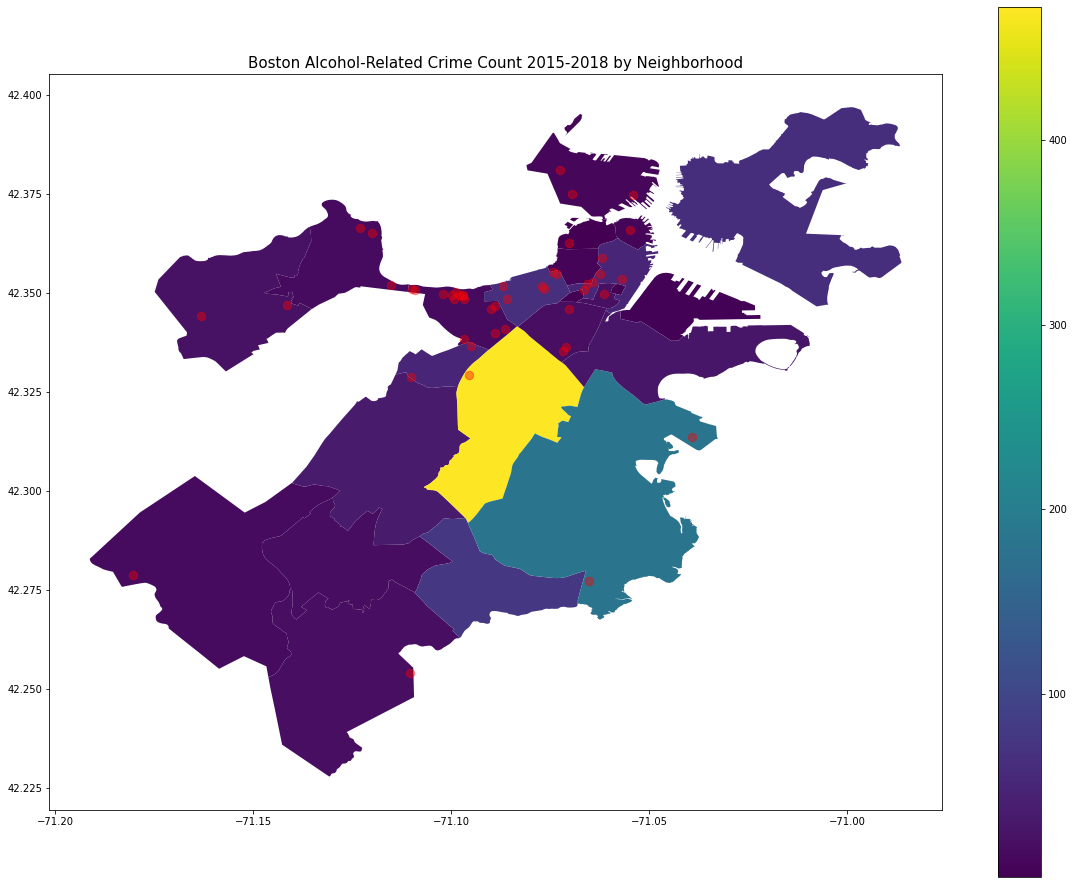

In [50]:
fig,ax = plt.subplots(figsize = (20,16))
crime_map = pd.merge(nb, combined_df, on="Neighborhood_ID")
crime_map.plot(ax = ax, column = 'crime', legend=True, figsize=(20,16))
g = c_geo_df.plot(ax=ax, markersize = 70, color = 'red', alpha=0.4)
plt.title('Boston Alcohol-Related Crime Count 2015-2018 by Neighborhood', fontsize = 15)
plt.show()

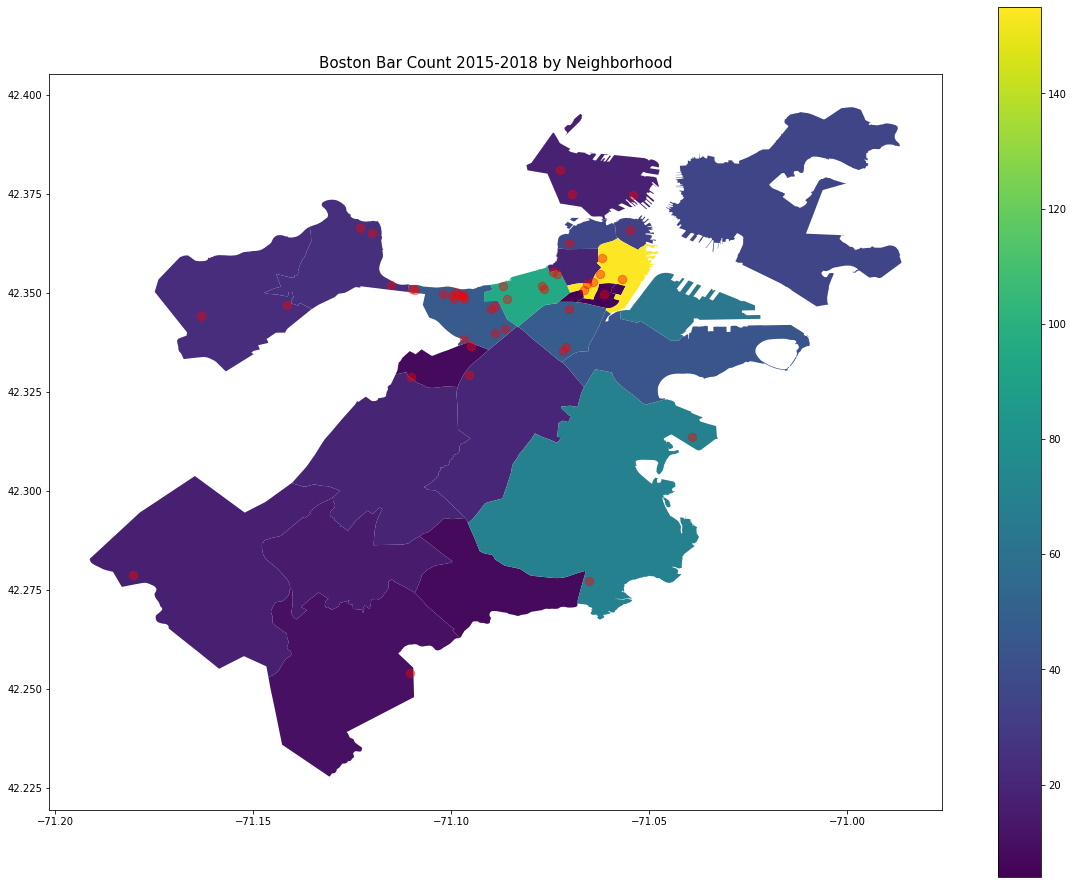

In [51]:
fig,ax = plt.subplots(figsize = (20,16))
bar_map = pd.merge(nb, combined_df, on="Neighborhood_ID")
bar_map.plot(ax=ax, column = 'bars', legend=True, figsize=(20,16))
g = c_geo_df.plot(ax=ax, markersize = 70, color = 'red', alpha=0.4)
plt.title('Boston Bar Count 2015-2018 by Neighborhood', fontsize = 15)
plt.show()

<a id='5'></a>
## 5. Analysis

In [52]:
correlation = combined_df.corr()
correlation

,crime,bars
crime,1.000000,0.056219
bars,0.056219,1.000000
